<a href="https://colab.research.google.com/github/OrhanDT/masterThesis/blob/main/Waldangelbach_Discharge_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('dataset.csv')
df.index = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')

In [3]:
discharge = df['discharge']

def df_to_X_y(df, window_size=1):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

WINDOW_SIZE = 100
X1, y1 = df_to_X_y(discharge, WINDOW_SIZE)

In [4]:
X_train1, y_train1 = X1[:49298], y1[:49298]
X_val1, y_val1 = X1[49922:67466], y1[49922:67466]
X_test1, y_test1 = X1[67466:], y1[67466:]

In [5]:
model1 = Sequential()
model1.add(InputLayer((100, 1)))
model1.add(LSTM(1))
model1.add(Dense(1))

model1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________


In [6]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.01), metrics=[RootMeanSquaredError()])

In [7]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=5, callbacks=[cp1])

Epoch 1/5
1538/1541 [============================>.] - ETA: 0s - loss: 0.0082 - root_mean_squared_error: 0.0904

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1541/1541 [==============================] - 42s 23ms/step - loss: 0.0082 - root_mean_squared_error: 0.0904 - val_loss: 0.0031 - val_root_mean_squared_error: 0.0558
Epoch 2/5
1540/1541 [============================>.] - ETA: 0s - loss: 0.0033 - root_mean_squared_error: 0.0576

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1541/1541 [==============================] - 33s 21ms/step - loss: 0.0033 - root_mean_squared_error: 0.0576 - val_loss: 0.0021 - val_root_mean_squared_error: 0.0454
Epoch 3/5
1541/1541 [==============================] - ETA: 0s - loss: 0.0029 - root_mean_squared_error: 0.0535

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1541/1541 [==============================] - 32s 21ms/step - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0424
Epoch 4/5
1541/1541 [==============================] - 29s 19ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0026 - val_root_mean_squared_error: 0.0505
Epoch 5/5
1539/1541 [============================>.] - ETA: 0s - loss: 0.0026 - root_mean_squared_error: 0.0514

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


1541/1541 [==============================] - 33s 21ms/step - loss: 0.0026 - root_mean_squared_error: 0.0513 - val_loss: 0.0018 - val_root_mean_squared_error: 0.0419


In [8]:
model1 = load_model('model1/')
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})

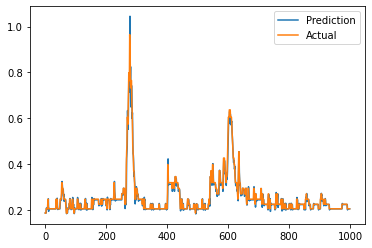

In [16]:
plt.plot(train_results['Train Predictions'][:1000],label = 'Prediction')
plt.plot(train_results['Actuals'][:1000],label = 'Actual')
plt.legend()

In [17]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})

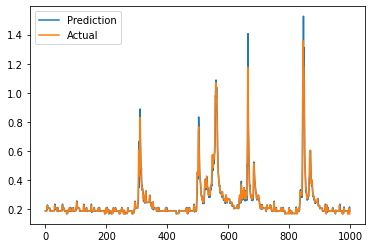

In [18]:
plt.plot(val_results['Val Predictions'][:1000],label = 'Prediction')
plt.plot(val_results['Actuals'][:1000],label = 'Actual')
plt.legend()

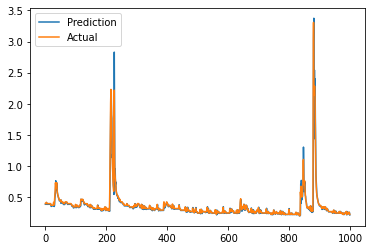

In [19]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
plt.plot(test_results['Test Predictions'][:1000],label = 'Prediction')
plt.plot(test_results['Actuals'][:1000],label = 'Actual')
plt.legend()

In [23]:
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

nse(test_results['Test Predictions'],test_results['Actuals'])

0.956388317820506